In [2]:
# !bash install.sh

In [52]:
%run prelude.py
%matplotlib inline
mpl.rcParams['figure.figsize'] = (20,5)


# Descriptive Statistics

# Datasets

We start by giving an overview over the datasets that we will use in the examples below.


300 values


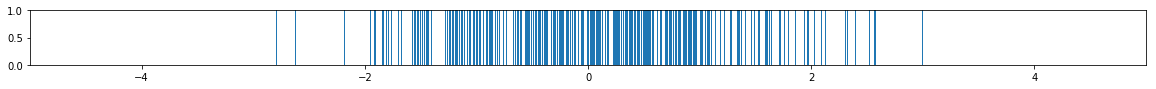

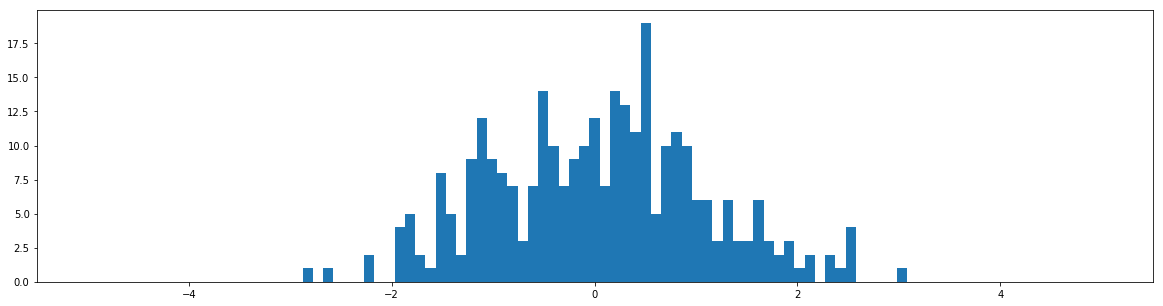

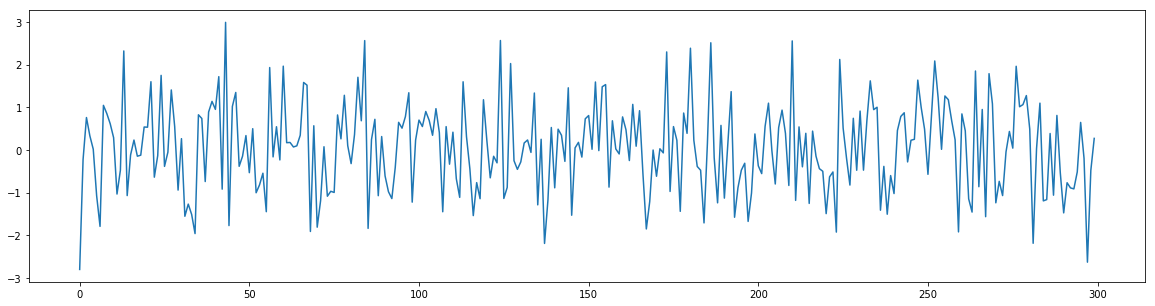

In [37]:
H("Normal Noise")
XNN = stats.norm.rvs(size=300)
print(len(XNN), "values")
plt.figure(figsize=(20,1))
plt.xlim(-5,5)
sns.rugplot(XNN,1);
plt.show()
plt.hist(XNN,bins=np.linspace(-5,5,100));
plt.show()
plt.plot(XNN)
plt.show()

76 values


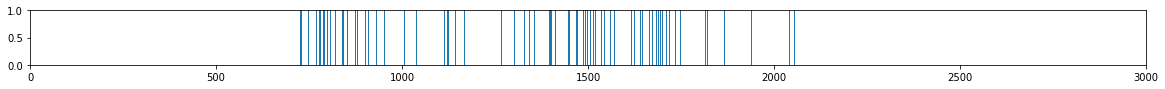

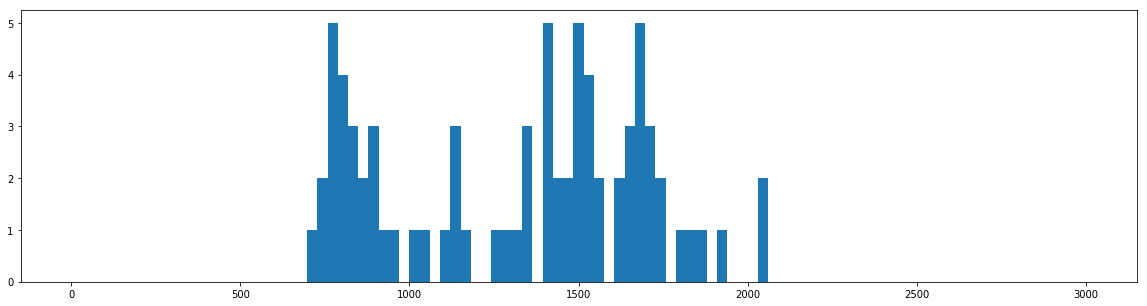

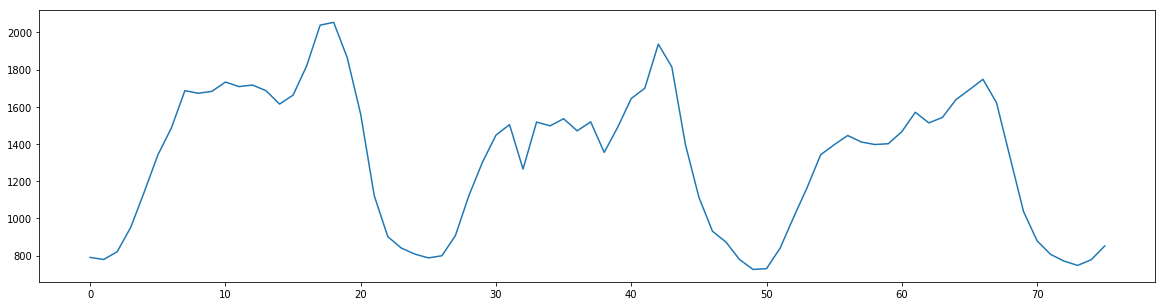

In [38]:
H("Request Rates")
XRR = np.loadtxt("../datasets/RequestRates.csv", delimiter=",")[:,1]
print(len(XRR), "values")
plt.figure(figsize=(20,1))
plt.xlim(0,3000)
sns.rugplot(XRR,1);
plt.show()
plt.hist(XRR,bins=np.linspace(0,3000,100));
plt.show()
plt.plot(XRR)
plt.show()

500 values


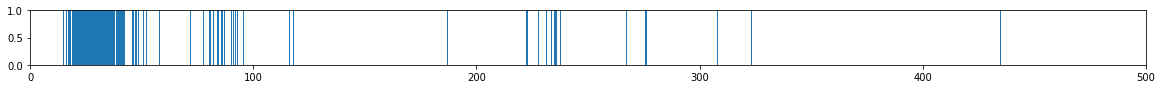

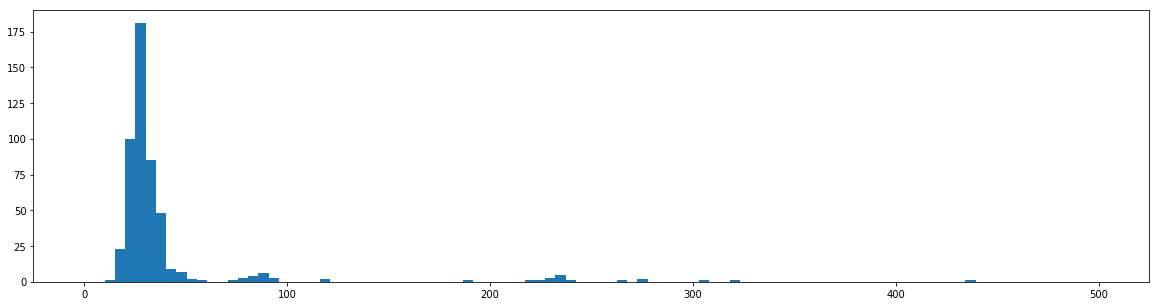

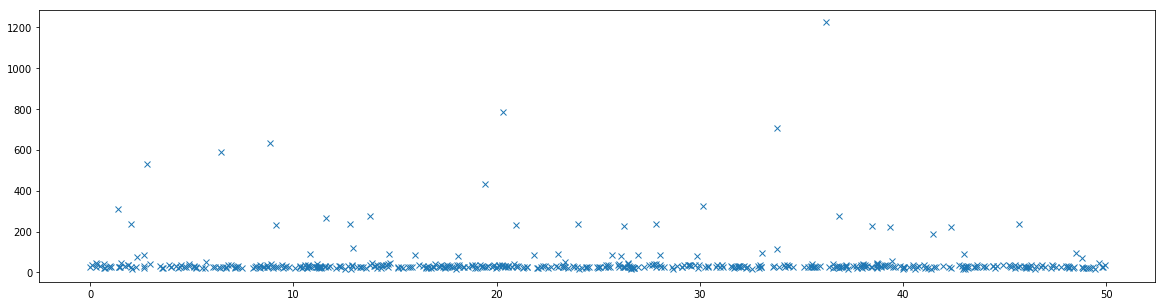

In [39]:
H("WebLatency")
XWL = np.genfromtxt("../datasets/WebLatency.csv", delimiter=",")[:,2][0:500] - 85
print(len(XWL), "values")
plt.figure(figsize=(20,1))
plt.xlim(0,500)
sns.rugplot(XWL,1);
plt.show()
plt.hist(XWL,bins=np.linspace(0,500,100));
plt.show()
plt.plot([np.random.uniform(0,50) for x in XWL],XWL,"x")
plt.show()

In [291]:
H("24x API Latencies")
FILENAME="../datasets/api_latencies_24x1h.tsv"
XAL = defaultdict(list)
with open(FILENAME) as fh:
    for line in fh:
        # line = "3 232.123321" -- hour latency
        a, b = line.split("\t")
        XAL[int(a)].append(float(b))
        
        
TAB([ [h, len(X)] for h,X in XAL.items() ], headers=["h", "count"])

  h    count
---  -------
  0    35212
  1    46133
  2    35794
  3    42859
  4    18253
  5      599
  6      280
  7       68
  8       99
  9       80
 10       25
 11       49
 12      105
 13      112
 14       93
 15       80
 16      376
 17    24570
 18    89914
 19    96013
 20   108017
 21    98110
 22   116548
 23    98134


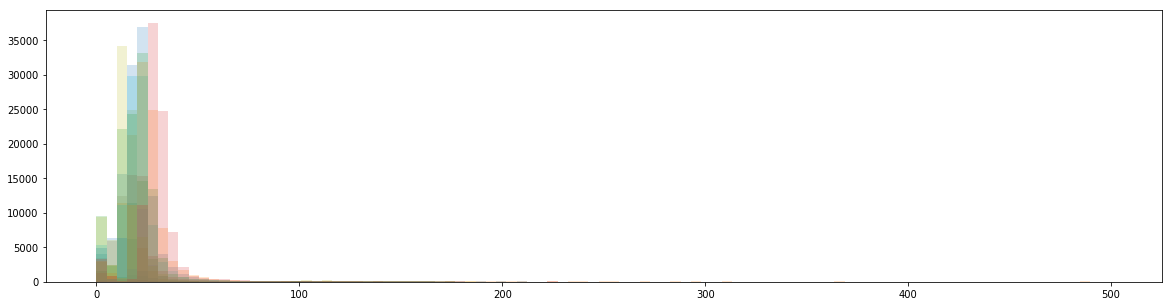

In [292]:
for h,X in XAL.items():
    plt.hist(X,bins=np.linspace(0,500,100), alpha=0.2);

# (1) Counting Values

The simplest way to summarize data is to count the samples in the datasets.
We consider the following functions:

In [176]:
def count(X):
    return len(X)

def count_below(X, y):
    return len([x for x in X if x <= y])

def ratio_below(X, y):
    return count_below(X,y)/count(X)

def count_above(X, y):
    return len([x for x in X if x > y])

def ratio_above(X, y):
    return count_above(X,y)/count(X)

## Fancy Names

The function `ratio_below(X,y)` also has fancy names:

* Empirical Comulative Distribution Function (CDF)

* Inverse Percentile

## Properties

### Mergability

* Counts are mergable: `count(X + Y) == count(X) + count(Y)`
* count_below() / count_above() is also mergable: `count_below(X + Y, y) == count(X,y) + count(Y,y)`
* ratio_below() is not mergable (on the nose), you need to remember the total count.

### Robustness

* count(X) is not affected by outliers at all.
* count_below() is robust: `count_below(X,x)` changes by max +/-1 if an outlier is added to the dataset.
* ratio_below() is robust as well.

In [177]:
def plot_count(X, xmin, xmax, N=200, rugs=True):
    grid = np.linspace(xmin,xmax,N)
    plt.plot(grid, [count_below(X,y) for y in grid],".-")
    if rugs: sns.rugplot(X)
    plt.xlim(xmin,xmax)

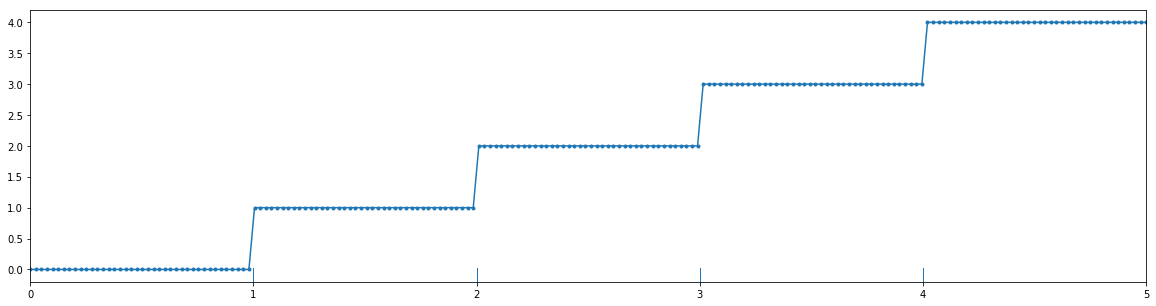

In [178]:
H("count_below on [1,2,3,4]")
plot_count([1,2,3,4], 0, 5)

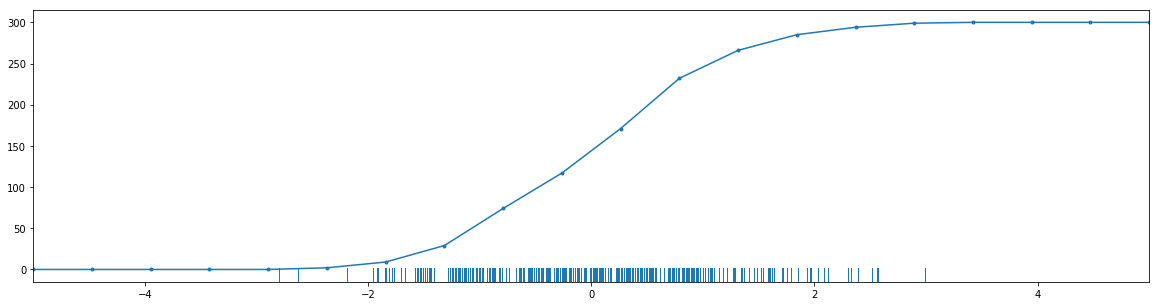

In [179]:
H("count_below on Normal Noise")
plot_count(XNN, -5, 5, N = 20)

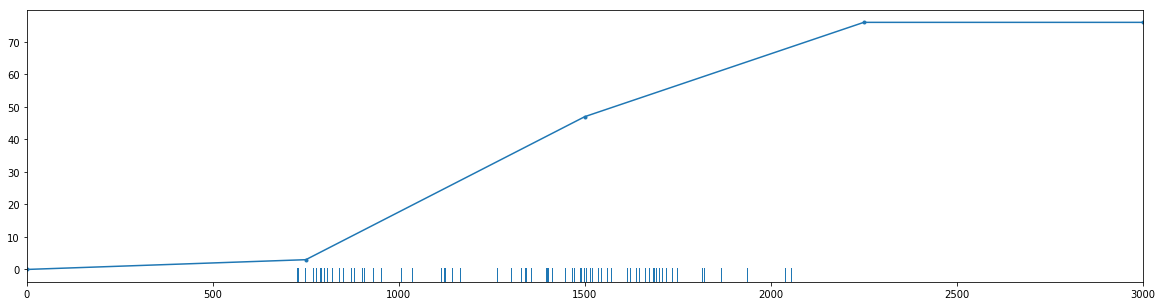

In [180]:
H("count_below() on RequestRates")
plot_count(XRR, 0, 3000, N = 5)

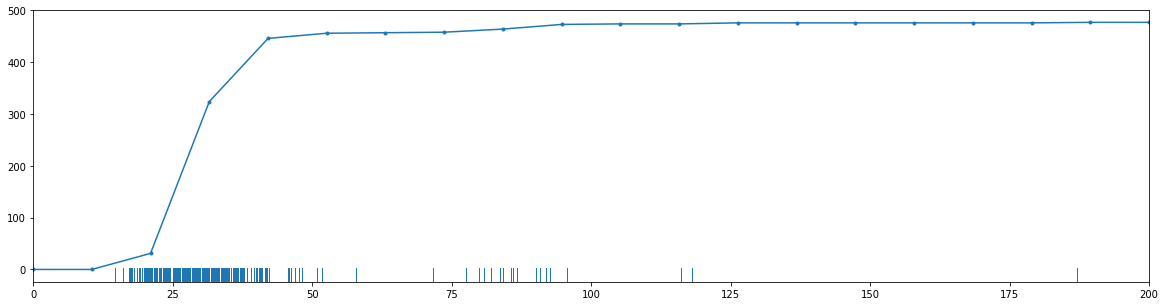

In [181]:
H("count_below() on WebLatencies")
plot_count(XWL, 0, 200, N = 20)

In [210]:
H("Tabulate count_above WebLatencies")
X = XWL
Y = [ 0, 5, 10, 50, 100, 1000, 10000 ]

TAB([(y, count_above(X, y), ratio_above(X, y) * 100 ) for y in Y ], headers=["threshold", "count_above", "ratio_above %"])

# print(tabulate)
# print(tabulate( [ [h, count(X)] + [ count_above(X, t) for t in  T ] for h, X in XAL.items() ] , headers = (["h", "count"] + T)))

  threshold    count_above    ratio_above %
-----------  -------------  ---------------
          0            500            100
          5            500            100
         10            500            100
         50             46              9.2
        100             26              5.2
       1000              1              0.2
      10000              0              0


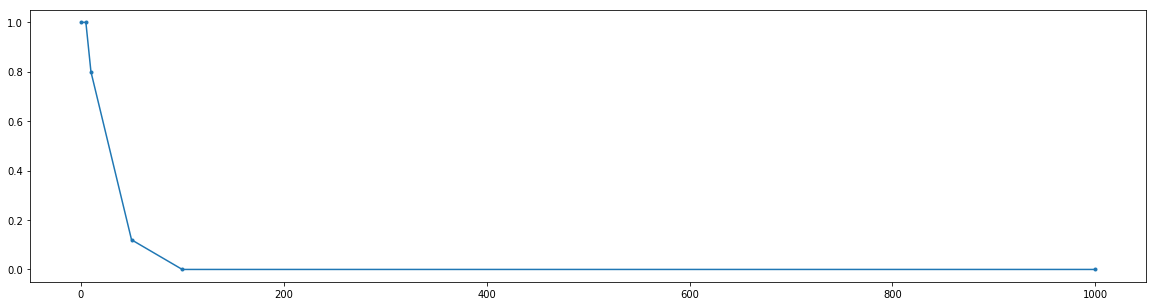

In [218]:
H("count_above() function for Web Latency data")
Y = [ 0, 5, 10, 50, 100, 1000 ]
# Y = np.linspace(0, 200, 50)
# Y = np.exp(np.linspace(0, 3, 50)*np.log(10))
plt.plot(Y, [ratio_above(X,y) for y in Y],".-")

This can be seen as a survival curve. The faster it goes to 0 the better the API performance was.

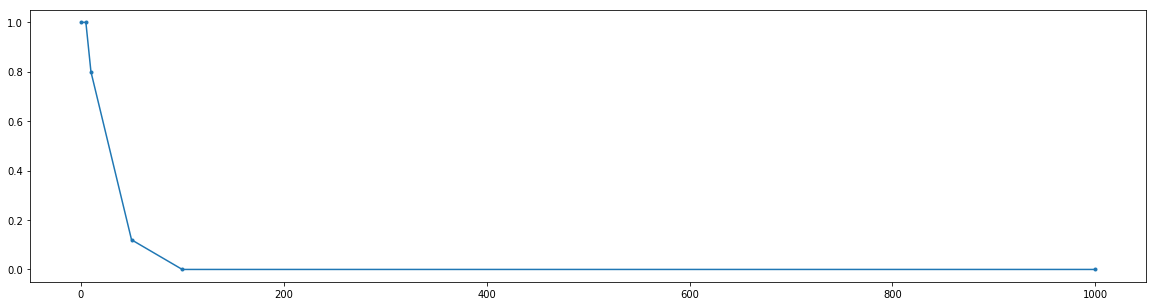

In [223]:
H("API Latency Example")
Y = [ 0, 5, 10, 50, 100, 1000 ]
# Y = np.linspace(0, 200, 50)
# Y = np.exp(np.linspace(0, 3, 50)*np.log(10))
X = XAL[10]
plt.plot(Y, [ratio_above(X,y) for y in Y],".-")

In [ ]:
# Y = [ 0, 5, 10, 50, 100, 1000 ]
# Y = np.exp(np.linspace(0, 3, 50)*np.log(10))



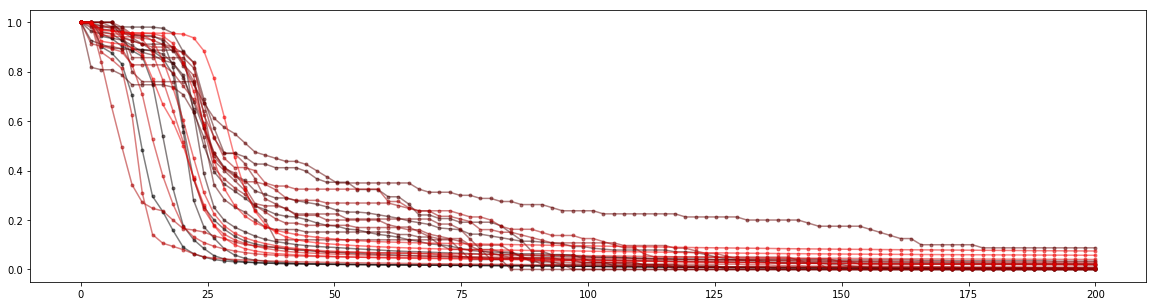

In [296]:
H("Survival function for 24h x API Latency data")
Y = np.linspace(0, 200, 100)
for h, X in XAL.items():
    plt.plot(Y, [ ratio_above(X,y) for y in Y ], ".-", alpha=0.5, color=((h)/24,0,0))

## Tabulate Bad API Latencies

Counting is a surprisingly effective way to evaluate API performance.

In [230]:
H("Tabulated API latency counts")
T = list(np.linspace(0, 100, 5))
T = [ 0, 5, 10, 50, 100, 1000, 2000, 5000, 10000 ] # thredholds
TAB( [ [h, count(X)] + [ count_above(X, t) for t in  T ] for h, X in XAL.items() ] , headers = (["h", "count"] + T))

  h    count       0       5      10     50    100    1000    2000    5000    10000
---  -------  ------  ------  ------  -----  -----  ------  ------  ------  -------
  0    35212   35212   31224   25115    746    464       7       0       0        0
  1    46133   46133   43298   40858    931    600      23       0       0        0
  2    35794   35794   34295   32012    757    447      27       1       0        0
  3    42859   42859   41577   40676   2968   1698     160      22       0        0
  4    18253   18253   17975   17906   1624    919      46       2       0        0
  5      599     599     542     534    105     31      16      14       0        0
  6      280     280     266     254     69     25       0       0       0        0
  7       68      68      68      63     24      3       0       0       0        0
  8       99      99      80      74     15      2       0       0       0        0
  9       80      80      80      75     28     19       1       1       1  

In [204]:
H("Slow Requests over the full day")
X_TOTAL = []
for X in XAL.values():
    for x in X:
        X_TOTAL.append(x)
TAB( [ ["full day  ", count(X_TOTAL)] + [ count_above(X_TOTAL, t) for t in  T ] ] , headers = (["h", "count"] + T))

h           count       0       5      10     50    100    1000    2000    5000    10000
--------  -------  ------  ------  ------  -----  -----  ------  ------  ------  -------
full day   811523  811523  762805  734530  54779  39330    9289    3612    1060      225


In [205]:
H("Total (column sum)")
# Calculated as Columnwise sum
TAB( [ ["column sum", sum(count(X) for X in XAL.values()) ] + [ sum(count_above(X, t) for X in XAL.values() )  for t in T ]  ], headers = (["h", "count"] + T) )

h             count       0       5      10     50    100    1000    2000    5000    10000
----------  -------  ------  ------  ------  -----  -----  ------  ------  ------  -------
column sum   811523  811523  762805  734530  54779  39330    9289    3612    1060      225


This illustrates the mergability property.

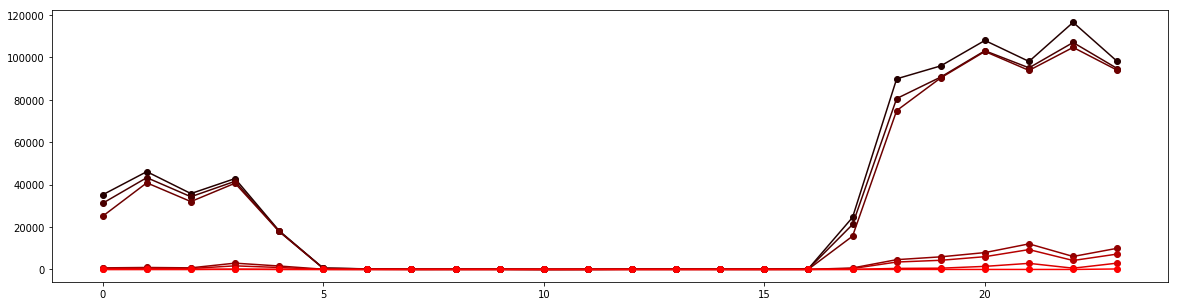

In [206]:
H("Plot slow API requests over time")
T = [ 0, 5, 10, 50, 100, 1000, 10000 ] # thredholds
# T = [  1000, 2000, 5000, 10000 ] # bad thredholds
for i, t in enumerate(T):
    plt.plot([ count_above(X, t) for h, X in XAL.items() ], "o-", color=((i+1)/len(T),0,0));
# plt.ylim(0, 100)

## Application:

- Count unhappy users: https://www.circonus.com/2016/06/percentages-arent-people/
  - Image: [Image](../img/unhappy-users.png)
  - Demo: https://demo.circonus.com/trending/graphs/view/5209437e-6fa9-4964-aa0b-2c59eb461cfa


- Latency SLOs

  > How many requests were served within 2000ms in the last month?

- Latency Bands in VividCoretex
  - [VividCortex](https://www.slideshare.net/vividcortex/monitoring-with-percentiles)
  - [Image](../img/banded-metrics.png)

- [Prometheus Histogram Metrics](https://prometheus.io/docs/concepts/metric_types/#histogram)

  > cumulative counters for the observation buckets, exposed as `<basename>_bucket{le="<upper inclusive bound>"}`


# (1) Mean Values

The _mean value_ of $X=[x_1, \dots, x_n]$ is defined as

$$ \mu = mean(X) = \frac{1}{n} \sum_{i=1}^n x_i. $$

- Represnets center of mass
- If the values are close together this is a good representative

In [158]:
# Computation of the mean value
def mean(X):
    return float(sum(X)) / len(X)

## Properties

* Mean values are not robust, a single outlier can skew the mean heavily.

* Mean values are mergable, if considered along with the count.


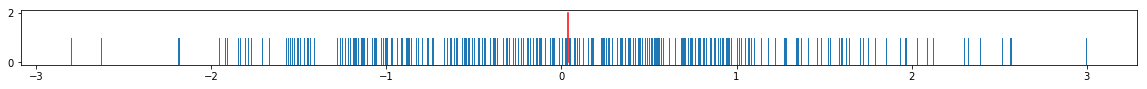

In [164]:
H("Example: Normal Data")
X = XNN
plt.figure(figsize=(20,1))
plt.plot([mean(X),mean(X)],[0,2],'r-')
sns.rugplot(X,height=.5)
plt.show()

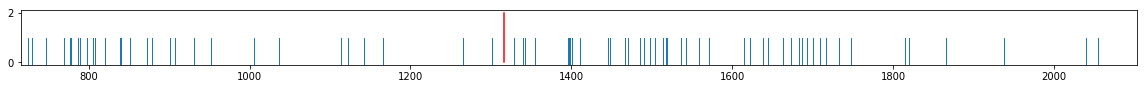

In [165]:
H("Example: Request Rates")
X = XRR
plt.figure(figsize=(20,1))
plt.plot([mean(X),mean(X)],[0,2],'r-')
sns.rugplot(X,height=.5)
plt.show()

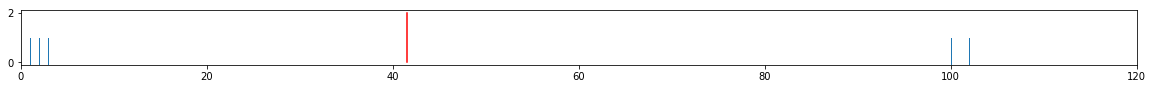

In [166]:
H("Mean values can be atypical")
X=[1,2,3,100,102]
plt.figure(figsize=(20,1))
plt.xlim(0,120)
plt.plot([mean(X),mean(X)],[0,2],'r-')
sns.rugplot(X,height=.5)
plt.show()

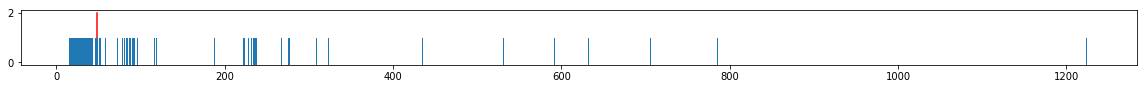

In [168]:
H("Example: WebLatency")
X = XWL
plt.figure(figsize=(20,1))
plt.plot([mean(X),mean(X)],[0,2],'r-')
sns.rugplot(X,height=.5)
plt.show()

In [169]:
H("Example API Latencies over time")
print(tabulate([ (h, count(X), mean(X)) for h, X in XAL.items() ], headers="hour count mean".split()))

  hour    count      mean
------  -------  --------
     0    35212   15.3844
     1    46133   19.5452
     2    35794   24.0116
     3    42859   37.0358
     4    18253   40.9685
     5      599   99.9001
     6      280   40.4061
     7       68   43.899
     8       99   28.9181
     9       80  154.951
    10       25   29.9061
    11       49   36.5057
    12      105   37.252
    13      112   34.9183
    14       93   44.7773
    15       80   45.7978
    16      376   17.1953
    17    24570   16.1729
    18    89914   31.9719
    19    96013   42.9325
    20   108017   63.3982
    21    98110  107.862
    22   116548   37.1995
    23    98134  171.847


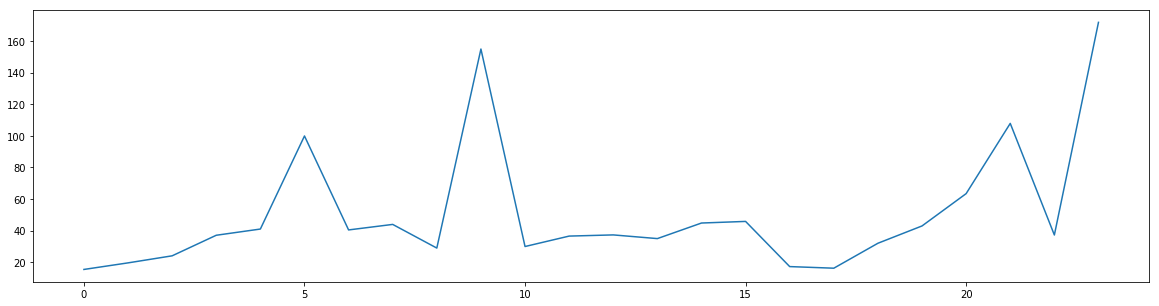

In [171]:
plt.plot([mean(X) for X in XAL.values()]);

**Exercise** Compute 1d mean values of the 24h API Latency dataset by aggregating 1h (counts, sums).

# Applications

* Main rollup aggregate used everywhere
* Used a lot for Graphing

# Mean Values are not suitable for summarizing latency data

> "Looking at your average response time is like measuring the average temperature of a hospital. What you really care about is a patient’s temperature, and in particular, the patients who need the most help." 

Dogan Ugurlu @ Optimizely

https://blog.optimizely.com/2013/12/11/why-cdn-balancing/


# (2) Median Vaules

A _median value_ for $x_1, \dots, x_n$ is number $m$ such that
  
 $$ \# \{ i \,|\, x_i \lt m \} = \# \{ i \,|\, x_i \gt m \}. $$

So the number of samples smaller than $m$ is equal to the number of samples larger than $m$.
(Both should be roughly $n/2$).
  
Remark:

* A Median always exists
* Median is not always unique
* Less "precise" then the mean for well behaved datasets

# The central median

Medians can be computed by sorting the dataset.

`S = sorted(X)`

Consider the following cases:

- if `len(X)` is odd, then `S[(len(X)-1)/2]` is the (unique and) central median.
- if `len(X)` is even, then all values between `S[len(X)/2-1]` and `S[len(X)/2]` are median values.  
  The central median is defined as the mean of those two values.

We write $median(X)$ for the central median of $X$.

Example:
* `median([1,2,3]) = 2`
* `median([1,2]) = (1 + 2) / 2`

## Properties

* Median values are robust, a single outlier not affect a median much.

* Median values are not mergable.

In [232]:
# Computation of the median
def median_range(X):
    S = sorted(X)
    n = len(X)
    lower_mid = int(math.floor((n-1)/2.))
    upper_mid = int(math.ceil((n-1)/2.))
    return (S[lower_mid], S[upper_mid])

def median(X):
    a,b = median_range(X)
    return (a+b)/2

In [233]:
def plot_median_range(X):
    plt.figure(figsize=(14,1))
    a, b = median_range(X)
    c = (a+b)/2.
    sns.rugplot(X, color="green", height=0.5)
    plt.plot([a,a],[0.5,1],'r-')
    plt.plot([b,b],[0.5,1],'r-')
    plt.plot([c,c],[0.5,1],'r-')
    plt.plot([a,b],[0.5,0.5],'r--')
    plt.title("Median Range: {:.3f} .. {:,.3f}".format(a,b))
    plt.ylim([0,1])

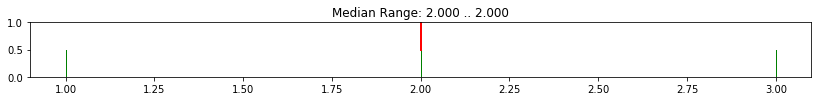

In [234]:
plot_median_range([1,2,3])

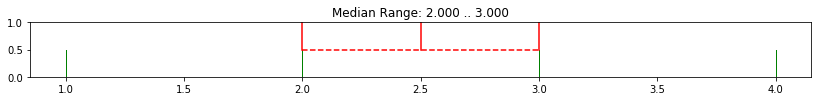

In [235]:
plot_median_range([1,2,3,4])

# Examples: Median

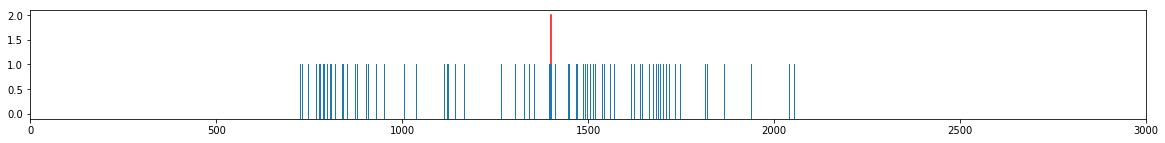

In [236]:
H("Example: Median Request Rate")
X = np.loadtxt("../datasets/RequestRates.csv", delimiter=",")[:,1]
plt.figure(figsize=(20,2))
plt.xlim(0,3000)
plt.plot([median(X),median(X)],[0,2],'r-')
sns.rugplot(X,height=.5);

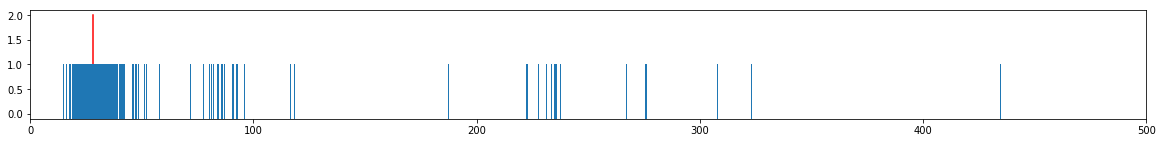

In [237]:
H("Example: Median WebLatency")
X = np.genfromtxt("../datasets/WebLatency.csv", delimiter=",")[:,2][0:500] - 85
plt.figure(figsize=(20,2))
plt.xlim(0,500)
plt.plot([median(X),median(X)],[0,2],'r-')
sns.rugplot(X,height=.5);

In [238]:
H("API Latencies over time")
print(tabulate([ (h, count(X), mean(X), median(X)) for h, X in XAL.items() ], headers="hour, count mean median".split()))

  hour,    count      mean    median
-------  -------  --------  --------
      0    35212   15.3844  11.9941
      1    46133   19.5452  16.5792
      2    35794   24.0116  20.5639
      3    42859   37.0358  20.8287
      4    18253   40.9685  23.2415
      5      599   99.9001  24.2814
      6      280   40.4061  25.5404
      7       68   43.899   26.8608
      8       99   28.9181  24.9067
      9       80  154.951   33.7054
     10       25   29.9061  25.3995
     11       49   36.5057  26.3385
     12      105   37.252   25.2334
     13      112   34.9183  25.2351
     14       93   44.7773  25.9111
     15       80   45.7978  27.2791
     16      376   17.1953   8.06479
     17    24570   16.1729  10.9114
     18    89914   31.9719  14.4872
     19    96013   42.9325  20.4149
     20   108017   63.3982  21.6036
     21    98110  107.862   25.4277
     22   116548   37.1995  20.1866
     23    98134  171.847   29.7161


The median latency was consistenly below 30 ms

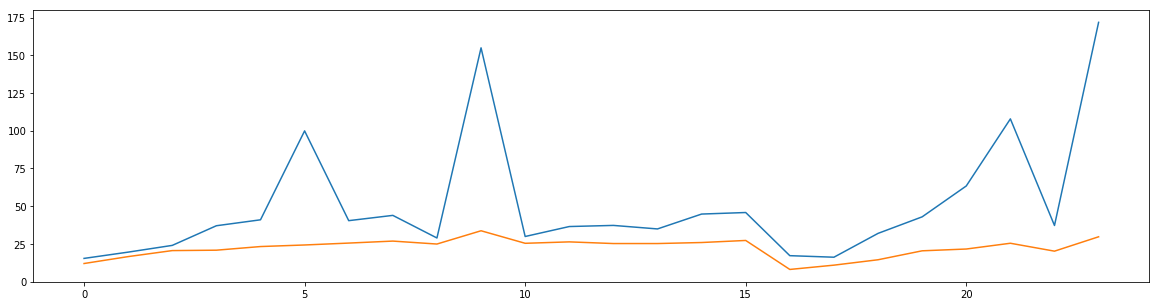

In [245]:
plt.plot([ (mean(X), median(X)) for h, X in XAL.items() ]);

# (3) Percentiles

The definition is a little involved so cover examples first

* The minimum is a 0%-percentile
* A median is a 50%-percentile
* The maximum is a 100%-percentile
* Quartiles: $0,25,50,75,100$-percentiles
* Quantiles: The $r$-quantile is the $r \times 100$-percentile $0<r<1$.

# General Definition of Percentiles

Pick a number $0\leq p \leq 100$. The (empirical) $p$%-percentile for $X$ is a value $y$ such that,

$$ \#\{i \,|\, X[i] \lt y \} \leq \frac{p}{100} \cdot n $$

and

$$ \#\{i \,|\, X[i] \gt y \} \leq \frac{100-p}{100} \cdot n $$

Roughly speaking, $y$ divides $X$ in $p\%$ samples that are lower than $y$ and $(100-p)\%$ samples that are larger than $y$.

Remarks:

* Percentiles always exists
* Non unique (like median)
* Multiple ways to pick a single value

# The Hyndman Fan List

There are many ways to define percentiles used in the wild.
Exhausive list by Hyndman-Fan, published in 1996.

> [1] Hyndman, R. J. and Fan, Y. (1996) Sample quantiles in statistical packages, American Statistician 50, 361–365. 10.2307/2684934

The percentiles we defined above are Type 1 percentiles in the Hydnam-Fan list.

From the perspective of Probablity Theory, this is the most natural definition.

In [246]:
from math import *
def PE_range(p, X):
    # Assumes X to be sorted
    q = p/100.0
    n = len(X)
    restrict = lambda x : max(1, min(n, x))
    a = restrict(ceil(q*n))
    b = restrict(floor(q*n) + 1)
    return (X[a-1], X[b-1])

def PE(p,X):
    # Assumes X to be sorted
    x,y = PE_range(p,X)
    return (x+y)/2

In [247]:
def mark_range(a,b):
    plt.plot([a,a],[0.5,1],'r-')
    plt.plot([b,b],[0.5,1],'r-')
    plt.plot([a,b],[0.75,0.75],'r--')

def plot_percentile_range(p,X):
    plt.figure(figsize=(14,2))
    sns.rugplot(X, color="green", height=0.5)
    a,b = PE_range(p,X)
    mark_range(a,b)
    plt.title("{:n}%-Percentile Range: {:.3f} .. {:,.3f}".format(p, a,b))
    plt.ylim([0,1])

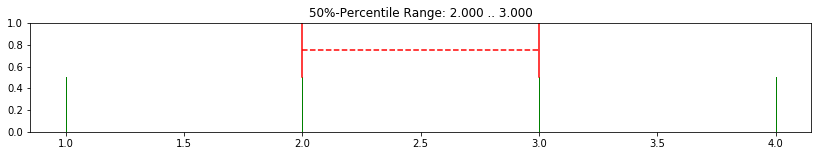

In [248]:
plot_percentile_range(50,[1,2,3,4])

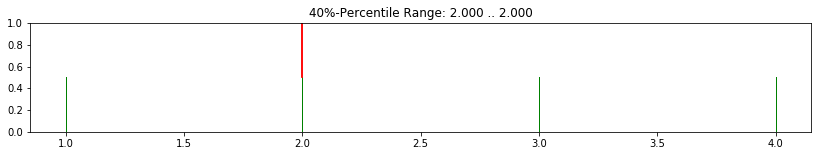

In [249]:
plot_percentile_range(40,[1,2,3,4])

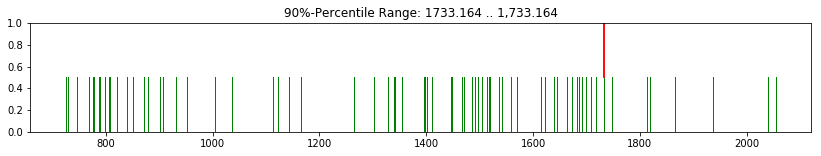

In [250]:
H("Example Request Rates p90")
X = sorted(XRR)
plot_percentile_range(90, X)

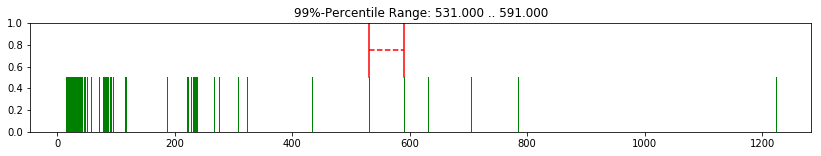

In [251]:
H("Example: WebLatency p99")
X = sorted(XWL)
plot_percentile_range(99, X)

-> make this unique by picking an odd number of samples

# The Percentile Function

We can consider the percentile as a function in p

In [301]:
def p_plot(X, *args):
    P = np.linspace(0, 100, 200)
    plt.plot(P, [PE(p, X) for p in P], *args)

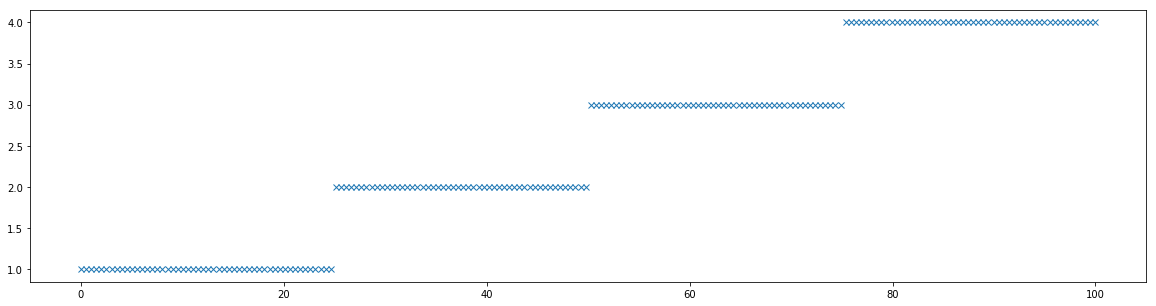

In [302]:
p_plot([1,2,3,4],"x")

# The Empirical Percentile function as inverse to the Emprical Distribution Function

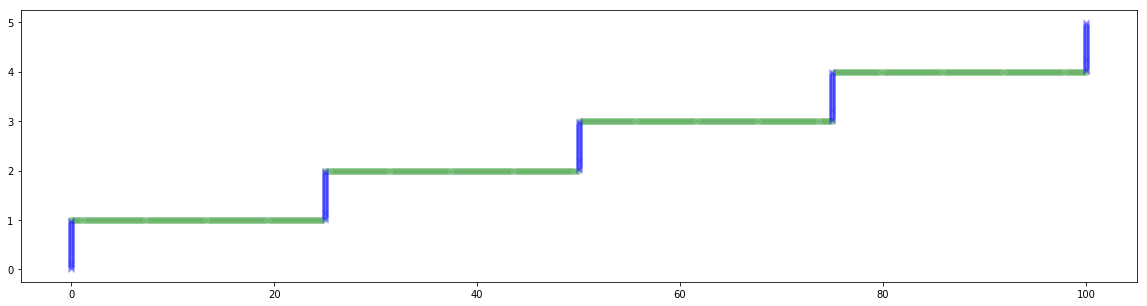

In [303]:
X = [1,2,3,4]
xlim = 5

P = np.linspace(0, 100, 500)
A = [ PE(p, X) for p in P ]

Y = np.linspace(0, xlim, 500)
B = [ ratio_below(X, y)*100 for y in Y]

plt.plot(P, A, "o", color="green", alpha=0.2)
plt.plot(B, Y, "x", color="blue", alpha=0.2)

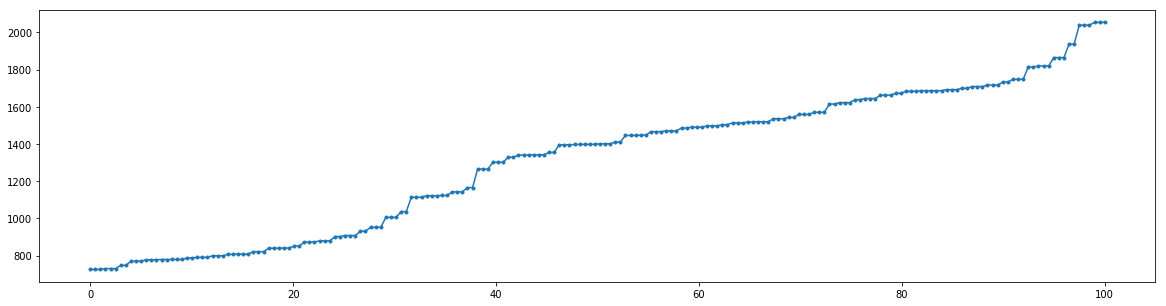

In [304]:
H("Percentile Function for Request Rates")
p_plot(sorted(XRR),".-")

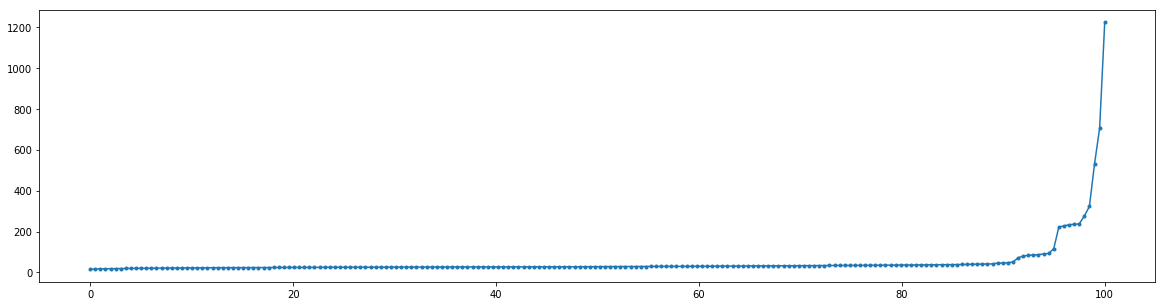

In [306]:
H("Percentile Function for WebLatencies")
p_plot(sorted(XWL),".-")

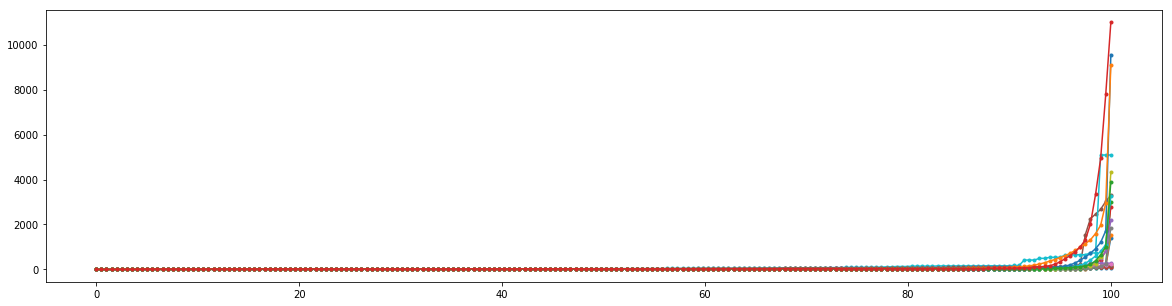

In [307]:
H("Percentile Function for API Latencies")
for h,X in XAL.items():
    p_plot(sorted(X),".-")

In [313]:
# TODO: Rescale x axes to 90, 99, 99.9, 99.99, ...

*Remark* The percentile function contains the same information as the latency survival function we have seen above

# Percentiles for the API Latency Dataset

In [315]:
P = [0, 50, 90, 99, 99.9, 100]
H("API Latencies over time")
print(tabulate([ [h, count(X)] + [ PE(p,X) for p in P ] for h, X in XAL.items() ], headers=["hour", "count"] + P, floatfmt=".1f" ))

  hour    count    0    50     90      99     99.9      100
------  -------  ---  ----  -----  ------  -------  -------
     0    35212  0.3  11.5   19.4   112.1    450.5   1406.1
     1    46133  0.4  16.2   23.7   117.8    606.6   1548.5
     2    35794  0.4  20.5   27.4   117.6    936.2   3001.0
     3    42859  0.3  20.8   35.0   421.4   1639.5   2776.4
     4    18253  0.4  23.1   42.9   499.1   1223.8   2195.7
     5      599  0.4  24.8   71.7  2877.5   3298.5   3298.5
     6      280  0.4  25.6   95.6   153.4    191.1    191.1
     7       68  7.2  26.5   87.3   125.5    125.5    125.5
     8       99  0.4  24.9   71.6   137.3    137.3    137.3
     9       80  7.7  33.7  168.4  5091.4   5091.4   5091.4
    10       25  7.6  25.4   73.7    83.2     83.2     83.2
    11       49  0.6  26.3   78.1    95.9     95.9     95.9
    12      105  7.5  25.5   75.8   115.3    249.3    249.3
    13      112  5.1  25.6   76.1   117.1    116.1    116.1
    14       93  0.5  25.9  105.1   277.

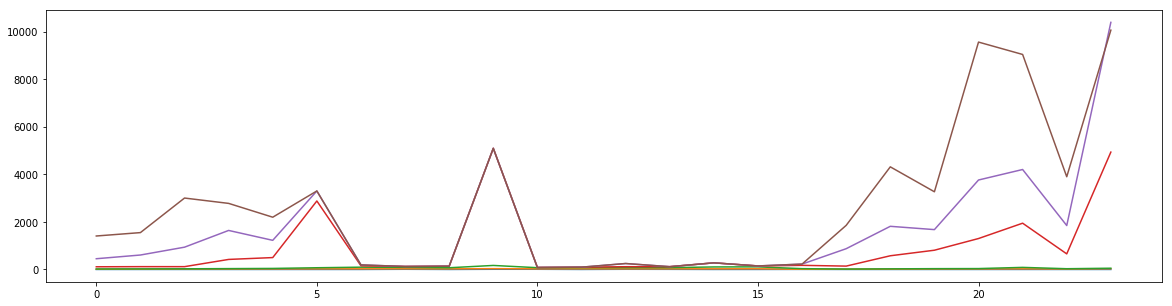

In [316]:
plt.plot([ [ PE(p,X) for p in P ] for h, X in XAL.items() ]  );

# Discussion

## Properties

* Percentiles are robust.

* Precentiles are not mergable (except: min/max) -> We will talk about this.

## Applications

* Service Level Monitoring: p99, p95 ([Dynamo paper](https://www.allthingsdistributed.com/2007/10/amazons_dynamo.html))

* Deviation measures (cf. next section)

# Type 7 percentiles

A slighyly different definition of quantiles is dominant in the Software industry, is the Type-7 percentile from the Hydman-Fan list.

Starting from the observation that:

*  $$ p(0,X) = min(X) = SX[1]$$

*  $$ p(100,X) = max(X) = SX[n] $$

where $SX$ is a sorted version of X.

The function:

$$ k(p) = \frac{p}{100} \cdot (\#X - 1) + 1$$

interpolates between $k(0) = 1$ and $k(100) = n$.

We define the Type-7 percentile range as:

$$  P^7_-(X,p) = SX[ floor(k(p)) ], \quad P^7_{+}(X,p) = SX[ ceil(k(p)) ]. $$

The interpolated Type-7 percentile, the unique piecewise linear function that interpolates between those values.


In [262]:
def P7_range(p, X):
    # assumes X to be sorted
    q = p/100.0
    n = len(X)
    a = floor((n-1) * q)
    b = ceil((n-1) * q)
    return X[a],X[b]

def P7(p, X):
    # assumes X to be sorted
    q = p/100.0
    n = len(X)
    a = floor((n-1) * q)
    b = ceil((n-1) * q)
    t = (n-1) * q - floor((n-1) * q)
    return X[a] * (1-t) + X[b] * (t)

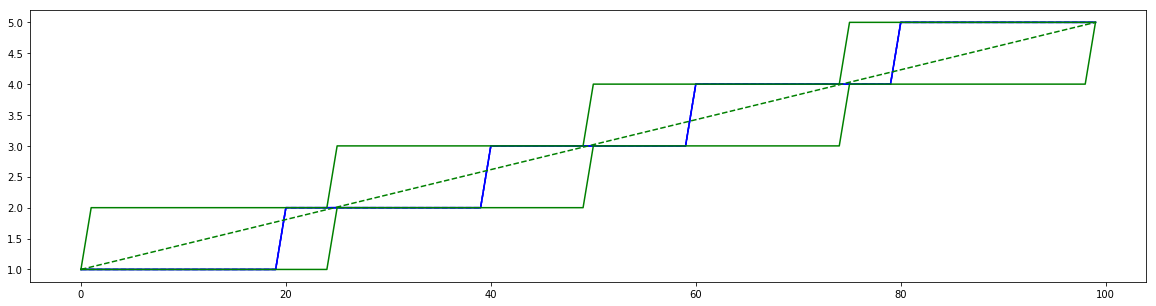

In [263]:
X = [1,2,3,4,5]
P = np.linspace(0,100,100)
plt.figure(figsize=(20,5))
plt.plot( [PE_range(p, X) for p in P], color="blue")
plt.plot( [PE(p, X) for p in P], "--", color="blue")
plt.plot( [P7_range(p, X) for p in P], color="green")
plt.plot( [P7(p, X) for p in P], "--", color="green")

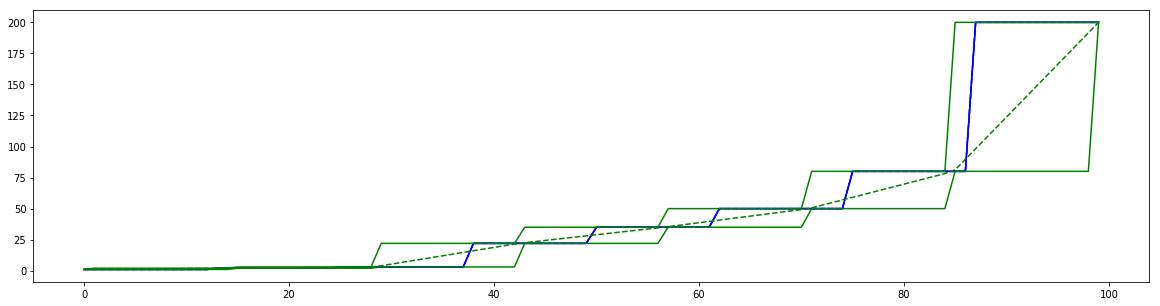

In [264]:
H("Differnces between Type-1 and Type-7 percentiles can be pronounced near extremal values")
X = [1,2,3,22,35,50,80,200]
P = np.linspace(0,100,100)
plt.figure(figsize=(20,5))
plt.plot( [PE_range(p, X) for p in P], color="blue")
plt.plot( [PE(p, X) for p in P], "--", color="blue")
plt.plot( [P7_range(p, X) for p in P], color="green")
plt.plot( [P7(p, X) for p in P], "--", color="green");

Elaboation: http://heinrichhartmann.com/math/quantiles.html